In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Brief Description of the problem and data(5 pts)**

Metastatic Cancer (source : https://www.cancer.gov/types/metastatic-cancer#what)

The process by which cancer cells spread to other parts of the body is called metastatsis. It is also called Stage IV Cancer.
When observed under a microscope and tested in other ways, metastatic cancer cells have features like that of the primary cancer and not like the cells in the place where the metastatic cancer is found. This is how doctors can tell that it is cancer that has spread from another part of the body.

The goal is to create a model to identify metastatic cancer in images taken from larger digital pathology scanes. The images are taken from modified version of PatchCamelyon(PCam) benchmark dataset. 

We are provided with small pathology images. The files are named with an image id. Positive lables indicates that the center 32x32px region of a patch contains atleast one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.


In [2]:
# import necessary libraries
# import necessary libraries
import numpy as np
import pandas as pd
import os

# Visuzalisation
import matplotlib.pyplot as plt
import seaborn as sns


**Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the data**


In [3]:
test_path = "/kaggle/input/histopathologic-cancer-detection/test/"
train_path = "/kaggle/input/histopathologic-cancer-detection/train/"
train_data = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv',dtype=str)


In [4]:
# Check the null values, shape , any other info from train_data
train_data.info()
train_data.isnull().sum()
train_data.shape
train_data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  object
dtypes: object(2)
memory usage: 3.4+ MB


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


id corresponds to the filenae of image in training path. There are two categories in label : 0 and 1. ) means non-cancerous and 1 is cancerous

In [5]:
# Check the distribution of data in train_data
train_data['label'].value_counts()

# percentage of positive and negative data
train_data['label'].value_counts()/len(train_data)

0    0.594969
1    0.405031
Name: label, dtype: float64

40% of the train data is Cancerous

In [6]:
print("No of Images in Training Set: {}".format(len(os.listdir(train_path))))
print("No of Images in Test Set: {}".format(len(os.listdir(test_path))))

No of Images in Training Set: 220025
No of Images in Test Set: 57458


**Sample random 10 images along with lables (mapping from training data) are displayed below**

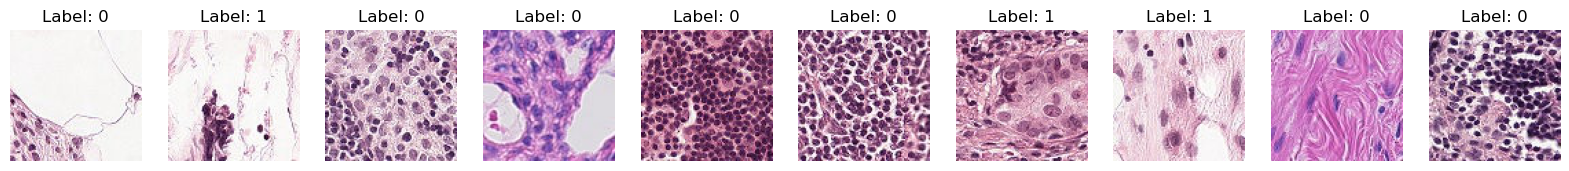

In [7]:
from matplotlib.image import imread
fig, ax = plt.subplots(1, 10, figsize=(20, 10))
for i in range(10):
    ax[i].imshow(imread(train_path + train_data['id'][i] + '.tif'))
    ax[i].axis('off')
    ax[i].set_title('Label: ' + str(train_data['label'][i]))
plt.show()

**Model Archicture**

In [8]:
# Importing Keras Libraries
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, BatchNormalization, Activation, Dropout
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import pydot
import graphviz
!pip install git+https://github.com/paulgavrikov/visualkeras




/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

  Cloning https://github.com/paulgavrikov/visualkeras to /tmp/pip-req-build-u8yv8341
  Running command git clone --filter=blob:none --quiet https://github.com/paulgavrikov/visualkeras /tmp/pip-req-build-u8yv8341
  Resolved https://github.com/paulgavrikov/visualkeras to commit cd169b81be347e2090353ad6fe2bd2e1f4020cf4
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 21.2 MB/s eta 0:00:0000:01
  Created wheel for visualkeras: filename=visualkeras-0.0.2-py3-none-any.whl size=13737 sha256=1f941df2b3f1c78ef440cadadccef4a9e3d1a2c3c0de26a0e120a567aa24cbd4
  Stored in directory: /tmp/pip-ephem-wheel-cache-cxn2fiv3/wheels/89/d3/c2/937382b33c09192fc84331bbc02c4565d62aeae67e9684c37e
Successfully built visualkeras


We are building a simple architecture commonly used for image classification tasks.

1. Conv2D (filters=16, kernel_size=(3,3), activation='relu'):
    - This is the first convolutional layer with 16 filters and a kernel size of 3x3.
    - The ReLU activation function is applied element-wise to introduce non-linearity.
    - This layer extracts 16 different feature maps from the input image.
2. Conv2D (filters=16, kernel_size=(3,3), activation='relu'):
    -  This is the second convolutional layer with the same configuration as the first layer.
    - It further extracts 16 feature maps from the previous layer's output.
3. MaxPool2D (pool_size=(2,2)):
    - This is the first max pooling layer with a pool size of 2x2.
    - It performs downsampling by taking the maximum value within each 2x2 region of the feature maps.
    - This helps to reduce the spatial dimensions and extract the most prominent features.
4. Conv2D (filters=32, kernel_size=(3,3), activation='relu'):
    - This is the third convolutional layer with 32 filters and a kernel size of 3x3.
    - It extracts 32 different feature maps from the output of the previous pooling layer.
5. Conv2D (filters=32, kernel_size=(3,3), activation='relu'):
    - This is the fourth convolutional layer with the same configuration as the previous layer.
    - It further extracts 32 feature maps from the previous layer's output.
6. MaxPool2D (pool_size=(2,2)):
    - This is the second max pooling layer with a pool size of 2x2.
    - It performs downsampling on the 32 feature maps obtained from the previous convolutional layer.
7. Flatten():
    - This layer flattens the 3D output from the previous max pooling layer into a 1D vector.
    - It converts the spatial representation of the features into a format that can be fed into the dense layers.
8. Dense(units=256, activation='relu'):
    - This is a fully connected (dense) layer with 256 units/neurons.
    - It serves as a hidden layer to learn complex relationships between the flattened input features.
9. Dense(units=1, activation='sigmoid'):
    - This is the final dense layer with a single unit.
    - It uses the sigmoid activation function to produce a probability output between 0 and 1.

Since this is a binary classification task (cancer or non-cancer), the output represents the probability of the input belonging to the positive class (cancer).

In [9]:
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

batch_size = 256

model.build(input_shape=(batch_size, 64, 64, 3))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (256, 62, 62, 16)         448       
                                                                 
 conv2d_1 (Conv2D)           (256, 60, 60, 16)         2320      
                                                                 
 max_pooling2d (MaxPooling2D  (256, 30, 30, 16)        0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (256, 28, 28, 32)         4640      
                                                                 
 conv2d_3 (Conv2D)           (256, 26, 26, 32)         9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (256, 13, 13, 32)        0         
 2D)                                                    

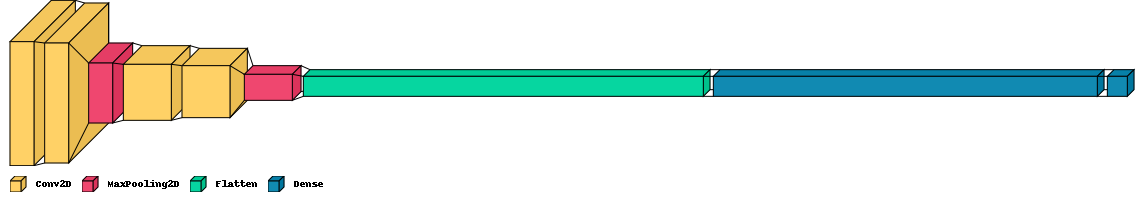

In [10]:
import visualkeras
visualkeras.layered_view(model, legend=True, scale_xy=2, scale_z=1.5)

In [11]:
def append_ext(fn):
    return fn+".tif"

train_data["id"]=train_data["id"].apply(append_ext)

train_df, valid_df = train_test_split(train_data, test_size=0.2, random_state=1, stratify=train_data.label)


In [12]:
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

In [13]:
train_loader = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = train_path,
    x_col = 'id',
    y_col = 'label',
    batch_size = 256,
    seed = 1,
    shuffle = True,
    class_mode = 'binary',
    target_size = (64,64)
)

valid_loader = train_datagen.flow_from_dataframe(
    dataframe = valid_df,
    directory = train_path,
    x_col = 'id',
    y_col = 'label',
    batch_size = 256,
    seed = 1,
    shuffle = True,
    class_mode = 'binary',
    target_size = (64,64)
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [14]:
opt = Adam(learning_rate=0.0001)

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])


In [15]:
history = model.fit(train_loader, validation_data=valid_loader, epochs=10)

Epoch 1/10
688/688 [==============================] - 1206s 2s/step - loss: 0.4789 - accuracy: 0.7756 - val_loss: 0.4588 - val_accuracy: 0.7857
Epoch 2/10
688/688 [==============================] - 365s 531ms/step - loss: 0.4312 - accuracy: 0.8056 - val_loss: 0.4283 - val_accuracy: 0.8097
Epoch 3/10
688/688 [==============================] - 342s 497ms/step - loss: 0.4044 - accuracy: 0.8210 - val_loss: 0.3929 - val_accuracy: 0.8275
Epoch 4/10
688/688 [==============================] - 334s 485ms/step - loss: 0.3888 - accuracy: 0.8295 - val_loss: 0.3857 - val_accuracy: 0.8319
Epoch 5/10
688/688 [==============================] - 368s 535ms/step - loss: 0.3810 - accuracy: 0.8332 - val_loss: 0.3741 - val_accuracy: 0.8360
Epoch 6/10
688/688 [==============================] - 322s 469ms/step - loss: 0.3695 - accuracy: 0.8392 - val_loss: 0.3684 - val_accuracy: 0.8418
Epoch 7/10
688/688 [==============================] - 309s 449ms/step - loss: 0.3643 - accuracy: 0.8419 - val_loss: 0.3607 - v

history = model.fit(train_loader, validation_data=valid_loader, epochs=10)

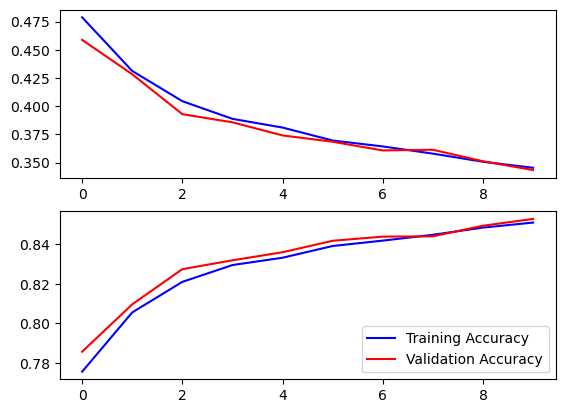

In [16]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label='Training Loss')
ax[0].plot(history.history['val_loss'], color='r', label='Validation Loss')

ax[1].plot(history.history['accuracy'], color='b', label='Training Accuracy')
ax[1].plot(history.history['val_accuracy'], color='r', label='Validation Accuracy')

plt.legend()

In [31]:
# print the best validation accuracy and loss
print("Best Validation Accuracy: ", max(history.history['val_accuracy']))
print("Best Validation Loss: ", min(history.history['val_loss']))


Best Validation Accuracy:  0.8528803586959839
Best Validation Loss:  0.34333735704421997


Since we used only 10 epochs, both the slopes seems to be converging . The final trianing accuracy after 10 epochs is 0.85 and validation accuracy is 0.8524

Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

**Building the Second Model**

**We are going to change few filters at each layer.  We will double filter size at each layer, keeping batch size same.**

**We are going to change few filters at each layer.  We will double filter size at each layer, keeping batch size same.**

- Convolutional layer 1: 32 filters
- Convolutional layer 2: 32 filters
- Convolutional layer 3: 64 filters
- Convolutional layer 4: 64 filters
- Dense layer: 64 units

Increasing the number of filters in the convolutional layers increases the capacity to capture more complex and diverse imaages. 

However, in model2, the number of units in the dense layer is reduced to 64 compared to 256 in model. This reduces the number of parameters in the dense layer, potentially reducing model complexity and preventing overfitting.

Overall, model2 can be seen as a slightly more complex model compared to model, with the ability to capture more diverse image features due to the increased number of filters in the convolutional layers. However, the reduction in dense layer units may affect the model's representation and learning capacity. Lets see how it fares compared to previous model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (256, 62, 62, 32)         896       
                                                                 
 conv2d_5 (Conv2D)           (256, 60, 60, 32)         9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (256, 30, 30, 32)        0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (256, 28, 28, 64)         18496     
                                                                 
 conv2d_7 (Conv2D)           (256, 26, 26, 64)         36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (256, 13, 13, 64)        0         
 2D)                                                  

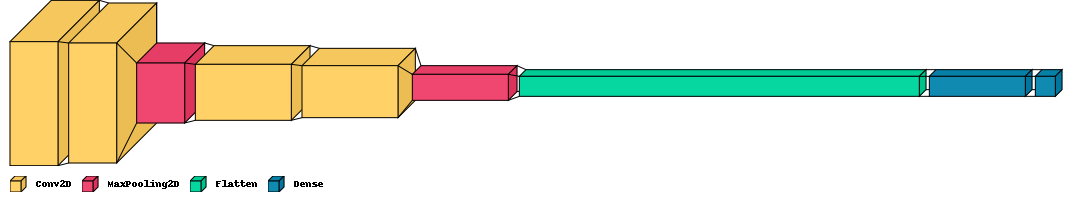

In [18]:
# Fine Tuning the model
model2 = Sequential()

model2.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model2.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model2.add(MaxPool2D(pool_size=(2,2)))

model2.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model2.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model2.add(MaxPool2D(pool_size=(2,2)))

model2.add(Flatten())
model2.add(Dense(units=64, activation='relu'))
model2.add(Dense(units=1, activation='sigmoid'))

batch_size = 256

model2.build(input_shape=(batch_size, 64, 64, 3))

model2.summary()

visualkeras.layered_view(model2, legend=True, scale_xy=2, scale_z=1.5)


In [20]:
adam_opt = Adam(learning_rate=0.0001)
model2.compile(optimizer=adam_opt, loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
history1 = model2.fit(train_loader, validation_data=valid_loader, epochs=10)

Epoch 1/10
688/688 [==============================] - 323s 470ms/step - loss: 0.4589 - accuracy: 0.7905 - val_loss: 0.4652 - val_accuracy: 0.7887
Epoch 2/10
688/688 [==============================] - 346s 503ms/step - loss: 0.4426 - accuracy: 0.7992 - val_loss: 0.4360 - val_accuracy: 0.8015
Epoch 3/10
688/688 [==============================] - 332s 482ms/step - loss: 0.4164 - accuracy: 0.8134 - val_loss: 0.4035 - val_accuracy: 0.8207
Epoch 4/10
688/688 [==============================] - 325s 472ms/step - loss: 0.3996 - accuracy: 0.8227 - val_loss: 0.4085 - val_accuracy: 0.8215
Epoch 5/10
688/688 [==============================] - 317s 460ms/step - loss: 0.3894 - accuracy: 0.8285 - val_loss: 0.3820 - val_accuracy: 0.8317
Epoch 6/10
688/688 [==============================] - 349s 507ms/step - loss: 0.3814 - accuracy: 0.8331 - val_loss: 0.3714 - val_accuracy: 0.8389
Epoch 7/10
688/688 [==============================] - 358s 520ms/step - loss: 0.3744 - accuracy: 0.8362 - val_loss: 0.3738 -

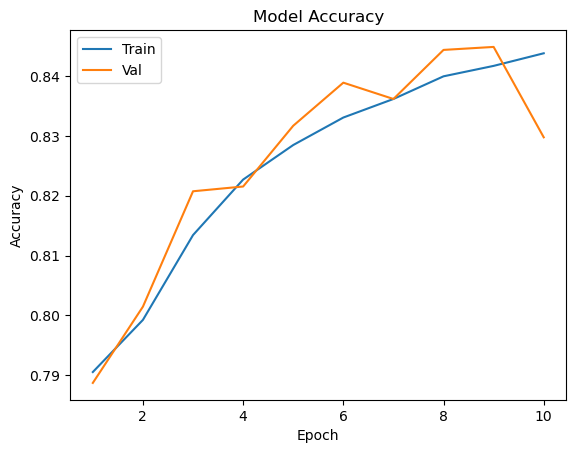

In [28]:
# Plot training and validation accuracy per epoch
epoch_range = range(1, 11)
plt.plot(epoch_range, history1.history['accuracy'])
plt.plot(epoch_range, history1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


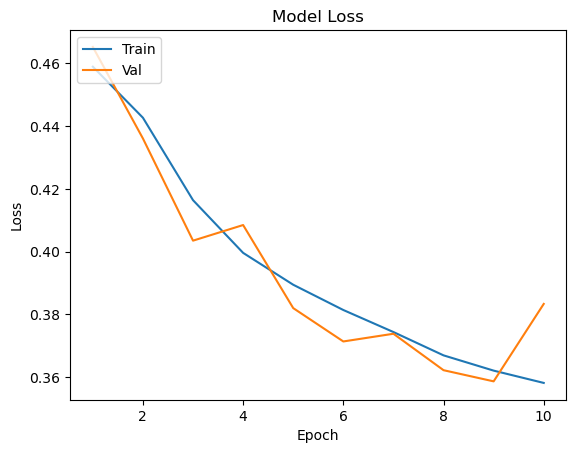

In [29]:
# Plot training and validation loss per epoch
epoch_range = range(1, 11)
plt.plot(epoch_range, history1.history['loss'])
plt.plot(epoch_range, history1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [30]:
# print the best validation accuracy and loss
print("Best Validation Accuracy: ", max(history1.history['val_accuracy']))
print("Best Validation Loss: ", min(history1.history['val_loss']))


Best Validation Accuracy:  0.8448812365531921
Best Validation Loss:  0.35865524411201477


**Conclusion**

The training accuracy and validation loss values of model and model2 are very similar, indicating that both models are performing comparably on the training and validation data.

The slight differences in training accuracy and validation loss between the two models can be small change in model complexity.

model and model2 have different architectural configurations, with variations in the number of filters in the convolutional layers and the number of units in the dense layers. These architectural differences can impact how the models learn and generalize to the data.



In [70]:
test_df = pd.DataFrame({'id':os.listdir(test_path)})
test_df.head()

,id
0,a7ea26360815d8492433b14cd8318607bcf99d9e.tif
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif


In [75]:
sample_submission = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')
sample_submission.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [76]:
# Add tif extension to id.
submission_df = pd.DataFrame({'id':os.listdir(test_path)})
submission_df.head()

,id
0,a7ea26360815d8492433b14cd8318607bcf99d9e.tif
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif


In [71]:
datagen_test = ImageDataGenerator(rescale=1./255.)

test_generator = datagen_test.flow_from_dataframe(
    dataframe=test_df,
    directory=test_path,
    x_col='id', 
    y_col=None,
    target_size=(64,64),         # original image = (96, 96) 
    batch_size=1,
    shuffle=False,
    class_mode=None)

Found 57458 validated image filenames.


In [72]:
predictions = model.predict(test_generator, verbose=1)

57458/57458 [==============================] - 182s 3ms/step


In [77]:
predictions = np.transpose(predictions)[0]
copy_df = pd.DataFrame()
copy_df['id'] = submission_df['id'].apply(lambda x: x.split('.')[0])
copy_df['label'] = list(map(lambda x: 0 if x < 0.5 else 1, predictions))
copy_df.head()

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,1
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0


In [78]:
copy_df['label'].value_counts()

0    36694
1    20764
Name: label, dtype: int64

In [79]:
copy_df.to_csv('submission.csv', index=False)